In [ ]:
import sys

sys.path.append("../")

A place to test random stuff

In [ ]:
from monkey.model.classification_model.efficientnet_b0 import (
    EfficientNet_B0,
)
import torch
import torch.nn as nn
from monkey.model.utils import (
    get_classification_metrics,
    get_activation_function,
)
from monkey.model.loss_functions import get_loss_function, dice_coeff
import numpy as np
from pprint import pprint

In [ ]:
true_mask = np.zeros(shape=(1, 2, 256, 256), dtype=np.float32)
true_mask[0, 0, :, :] = 1
true_mask = torch.tensor(
    true_mask, dtype=torch.float32, requires_grad=True
)

# pprint(true_mask)
pred_mask = np.zeros(shape=(1, 2, 256, 256), dtype=np.float32)
pred_mask[0, 0, :, :] = 1
pred_mask[0, 1, :, :] = 1
pred_mask = torch.tensor(
    pred_mask, dtype=torch.float32, requires_grad=True
)

dice_loss_fn = get_loss_function("Dice")
dice_loss_fn.set_multiclass(True)

dice_loss = dice_loss_fn.compute_loss(true_mask, pred_mask)

pprint(dice_loss)

CONCH

In [ ]:
from conch.open_clip_custom import (
    create_model_from_pretrained,
    tokenize,
    get_tokenizer,
)
import torch
import os
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm

In [ ]:
model_cfg = "conch_ViT-B-16"
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)
checkpoint_path = "/home/u1910100/Downloads/pytorch_model.bin"
model, preprocess = create_model_from_pretrained(
    model_cfg, checkpoint_path, device=device
)
_ = model.eval()

tokenizer = get_tokenizer()
classes = ["lymphocyte", "monocyte"]
prompts = [
    "a PAS stained image of a lymphocyte",
    "a PAS stained image of a monocyte",
]

tokenized_prompts = tokenize(texts=prompts, tokenizer=tokenizer).to(
    device
)
tokenized_prompts.shape

In [ ]:
from monkey.data.dataset import get_classification_dataloaders
from monkey.config import TrainingIOConfig

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/classification",
    save_dir="./",
)
IOconfig.set_image_dir(
    "/home/u1910100/Documents/Monkey/classification/patches"
)
IOconfig.set_mask_dir(
    "/home/u1910100/Documents/Monkey/classification/patches"
)
batch_size = 32
train_loader, val_loader = get_classification_dataloaders(
    IOconfig,
    val_fold=1,
    batch_size=batch_size,
    do_augmentation=True,
)

In [ ]:
pred_probs_list = []
true_labels_list = []

for data in tqdm(val_loader):
    file_ids = data["id"]

    images, true_labels = (
        data["image"].cuda().float(),
        data["label"].cpu().tolist(),
    )

    true_labels_list.extend(true_labels)
    pred_probs = []

    with torch.inference_mode():
        image_embedings = model.encode_image(images)
        text_embedings = model.encode_text(tokenized_prompts)
        sim_scores = (
            (
                image_embedings
                @ text_embedings.T
                * model.logit_scale.exp()
            )
            .softmax(dim=-1)
            .cpu()
            .numpy()
        )

        pred_probs_list.extend(sim_scores[:, 1])

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from monkey.model.utils import get_classification_metrics

pred_probs_list = np.array(pred_probs_list)
true_labels_list = np.array(true_labels_list)
fpr, tpr, thresholds = metrics.roc_curve(
    true_labels_list, pred_probs_list
)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=roc_auc,
    estimator_name="cell classifier",
)
display.plot()
plt.show()

thresh = 0.5
pred_labels_list = np.where(pred_probs_list > thresh, 1, 0)
scores = get_classification_metrics(
    true_labels_list, pred_labels_list
)
print(scores)
metrics.ConfusionMatrixDisplay.from_predictions(
    true_labels_list,
    pred_labels_list,
    display_labels=["lymphocyte", "monocyte"],
)
plt.show()

In [ ]:
data = next(iter(val_loader))
images = data["image"].to("cuda").float()
print(data["label"])

with torch.inference_mode():
    image_embedings = model.encode_image(images)
    text_embedings = model.encode_text(tokenized_prompts)
    sim_scores = (
        (image_embedings @ text_embedings.T * model.logit_scale.exp())
        .softmax(dim=-1)
        .cpu()
        .numpy()
    )

pred_class = sim_scores.argmax()
print(pred_class)
print(sim_scores)
print(sim_scores[:, 1])
# print("Predicted class:", classes[sim_scores.argmax()])
# print(
#     "Normalized similarity scores:",
#     [
#         f"{cls}: {score:.3f}"
#         for cls, score in zip(classes, sim_scores[0])
#     ],
# )

CellViT

In [ ]:
import torch
from monkey.model.cellvit.cellvit import CellViT256

model_path = "/home/u1910100/Downloads/CellViT-256-x40.pth"
device = "cuda"

model_checkpoint = torch.load(model_path)
print(model_checkpoint["arch"])
print(model_checkpoint["config"])

model = CellViT256(
    model256_path=None,
    num_nuclei_classes=6,
    num_tissue_classes=19,
    regression_loss=False,
)

model.load_state_dict(model_checkpoint["model_state_dict"])

model.eval()
model.to("cuda")

MapDe Filter

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import sys
from scipy import ndimage, signal

sys.path.append("../")
from monkey.data.data_utils import erode_mask, generate_regression_map
import cv2
from skimage import draw

cell_mask = np.zeros(shape=(256, 256), dtype=np.uint8)
rr, cc = draw.ellipse(100, 100, 1, 1, shape=cell_mask.shape)
# rr, cc = 100, 100
cell_mask[rr, cc] = 1
plt.imshow(cell_mask)
plt.show()


def gauss_2d_filter(shape=(11, 11)):
    sigma = int((shape[0] - 1) / 6)
    m, n = [(ss - 1.0) / 2.0 for ss in shape]
    y, x = np.ogrid[-m : m + 1, -n : n + 1]
    h = np.exp(-(x * x + y * y) / (2.0 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh

    h = h / (h[int(m), int(n)])
    return h


dist_filter = gauss_2d_filter(shape=(17, 17))
plt.imshow(dist_filter)
plt.show()
# cell_mask = generate_regression_map(cell_mask, d_thresh=5, alpha=0.5, scale=1)
# plt.imshow(cell_mask)
# plt.show()

cell_mask = signal.convolve2d(cell_mask, dist_filter)
print(np.max(cell_mask))
plt.imshow(cell_mask)
plt.show()

Multihead Unet

In [ ]:
import sys

sys.path.append("../")
from pprint import pprint
import torch

torch.manual_seed(0)
from torchvision.models.efficientnet import (
    efficientnet_b0,
)
from monkey.model.efficientunetb0.architecture import (
    get_multihead_efficientunet,
)
from torchinfo import summary


model = get_multihead_efficientunet(
    out_channels=[2, 1], pretrained=True
)
model.eval()
model.to("cuda")
summary(model, input_size=(1, 3, 256, 256))

In [ ]:
with torch.no_grad():
    test_input = torch.ones(
        size=(1, 3, 256, 256), dtype=torch.float, device="cuda"
    )
    model_out = model(test_input)
    pprint(model_out)

MapDe model

In [1]:
import sys
import torch

sys.path.append("../")

from monkey.model.mapde.model import MapDe
from monkey.data.dataset import get_detection_dataloaders
from monkey.config import TrainingIOConfig
import matplotlib.pyplot as plt
import numpy as np
from monkey.data.data_utils import imagenet_denormalise
import torch

use_nuclick_masks = False
batch_size = 1
module = "detection"

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/patches_256",
    save_dir="./",
)


train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=5,
    dataset_name="detection",
    batch_size=batch_size,
    disk_radius=1,
    regression_map=False,
    do_augmentation=True,
    module=module,
    use_nuclick_masks=use_nuclick_masks,
    include_background_channel=False,
)


model = MapDe(3, 30, 50, num_classes=1, filter_size=31)
model.eval()
# print(model)
test_input = torch.ones(size=(4, 3, 252, 252), dtype=torch.float)

with torch.no_grad():
    out = model(test_input)
print(f"output size = {out.size()}")
# print(torch.max(out))

/home/u1910100/miniconda3/envs/tiatoolbox/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2339, 1518, 1678, 5869]
train patches: 11404
test patches: 2911
output size = torch.Size([4, 1, 252, 252])


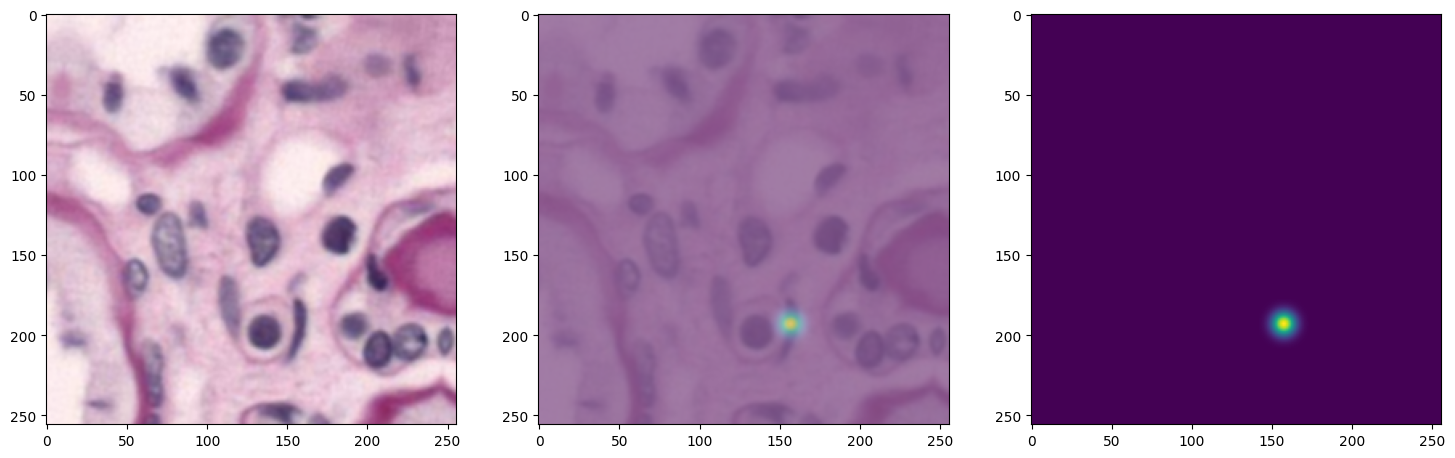

In [5]:
data = next(iter(train_loader))

fig, axes = plt.subplots(1, 3, figsize=(18, 18))

image = data["image"][0].numpy()
image = np.moveaxis(image, 0, 2)
image = imagenet_denormalise(image)
axes[0].imshow(image)

mask = data["mask"]
mask_filtered = model.blur_cell_points(mask)


axes[1].imshow(image, alpha=0.5)
mask_filtered_numpy = mask_filtered.numpy()
axes[1].imshow(mask_filtered_numpy[0][0], alpha=0.5)
axes[2].imshow(mask_filtered_numpy[0][0])
plt.show()

tensor([[[[16.0203, 18.1314, 20.0478,  ..., 18.6048, 16.2585, 13.8594],
          [18.8250, 21.2690, 23.4751,  ..., 21.2291, 18.5729, 15.8552],
          [21.6138, 24.3848, 26.8738,  ..., 23.6072, 20.6739, 17.6723],
          ...,
          [17.5620, 20.5775, 23.6765,  ..., 22.0228, 19.4789, 16.8532],
          [15.6090, 18.2986, 21.0656,  ..., 19.9520, 17.6685, 15.2991],
          [13.5728, 15.9179, 18.3323,  ..., 17.6451, 15.6419, 13.5538]]],


        [[[14.7538, 16.7483, 18.5995,  ..., 17.6233, 15.3900, 13.1086],
          [17.3209, 19.6335, 21.7700,  ..., 19.9296, 17.4311, 14.8757],
          [19.8648, 22.4880, 24.9014,  ..., 21.9806, 19.2496, 16.4553],
          ...,
          [19.1631, 22.6312, 26.1844,  ..., 24.4361, 21.7084, 18.8633],
          [17.0052, 20.1111, 23.2966,  ..., 21.9317, 19.5184, 16.9892],
          [14.7436, 17.4603, 20.2496,  ..., 19.2373, 17.1469, 14.9468]]]])


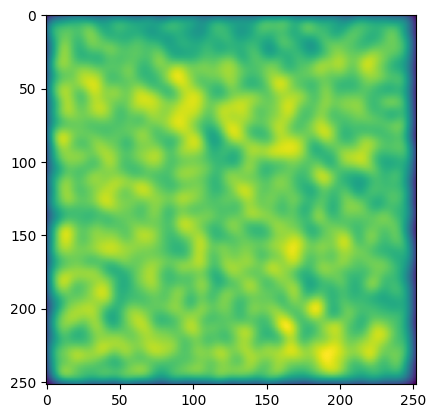

72.34132


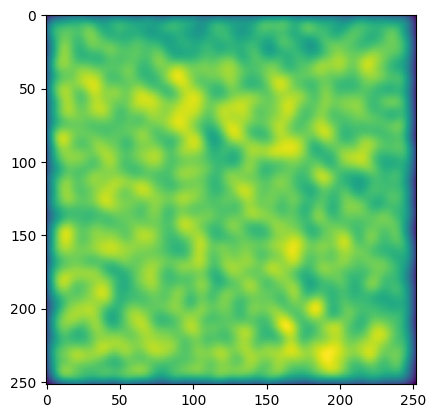

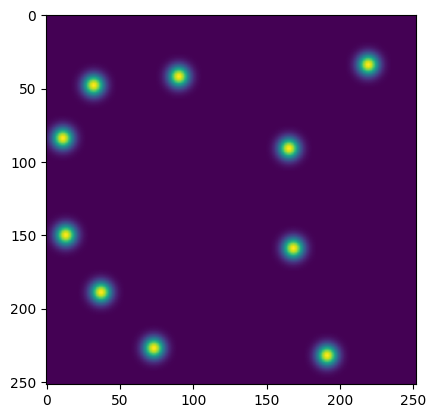

219.0 34.0 0.93188417
90.0 42.0 0.9704904
32.0 48.0 0.9497022
11.0 84.0 0.9280029
165.0 91.0 0.9647528
13.0 150.0 0.95277953
168.0 159.0 0.97234833
37.0 189.0 0.93667793
73.0 227.0 0.91721964
191.0 232.0 1.0


In [2]:
test_logits = torch.rand(size=(2, 3, 252, 252))

model.eval()
with torch.no_grad():
    logits = model(test_logits)
    probs = model.logits_to_probs(logits)
print(logits)

out_masks = model.postproc(logits)
out_masks = out_masks[:, np.newaxis, :, :]
out_masks = model.blur_cell_points(out_masks)

logits = logits.numpy(force=True)
probs = probs.numpy(force=True)


plt.imshow(logits[0][0])
plt.show()
print(np.max(logits[0][0]))

plt.imshow(probs[0][0])
plt.show()

# print(np.max(logits))
plt.imshow(out_masks[0][0])
plt.show()

import skimage

inflamm_labels = skimage.measure.label(out_masks[0][0])
inflamm_stats = skimage.measure.regionprops(
    inflamm_labels, intensity_image=probs[0][0]
)
for region in inflamm_stats:
    centroid = region["centroid"]

    c, r, confidence = (
        centroid[1],
        centroid[0],
        region["mean_intensity"],
    )
    print(c, r, confidence)

HoverNext

In [ ]:
import sys
import torch

sys.path.append("../")

from monkey.model.hovernext.model import get_model

model = get_model(
    out_channels_cls=2,
)
model.eval()
print(model)